<a href="https://colab.research.google.com/github/harshitha2403/Hate-Speech-Detection/blob/main/Final_DGH_Roberta_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.8 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from transformers import Trainer, TrainingArguments
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
import numpy as np
from sklearn.metrics import precision_score, f1_score, confusion_matrix,classification_report, ConfusionMatrixDisplay
from datasets import load_metric
import torch
from transformers import TrainingArguments, Trainer
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import RobertaTokenizer, RobertaForSequenceClassification

In [ ]:
#Loading the dataset
train = pd.read_csv("drive/My Drive/DGH/trainDGH.csv")
test = pd.read_csv("drive/My Drive/DGH/testDGH.csv")

In [ ]:
#sving it to csv
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

In [ ]:
# Loading the dataset
dataset = load_dataset('csv', data_files={'train': 'train.csv', 'test': 'test.csv'})

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
#Initializing the tokenizer and the model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

#tokenizing
tokenized_datasets = dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/30858 [00:00<?, ? examples/s]

Map:   0%|          | 0/10286 [00:00<?, ? examples/s]

In [ ]:
#collecting function
def collate_fn(batch):
    return {
        'input_ids': torch.stack([item['input_ids'] for item in batch]),
        'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
        'labels': torch.tensor([item['labels'] for item in batch])
    }

train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["test"]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)


In [ ]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    cm = confusion_matrix(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall, "confusion_matrix": cm.tolist()}


In [ ]:

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=500,
    evaluation_strategy="steps",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics
)

trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Confusion Matrix
500,0.577500,0.458971,0.786311,0.806173,0.788647,0.824495,"[[3517, 1225], [973, 4571]]"
1000,0.458500,0.413723,0.804394,0.806836,0.862479,0.757937,"[[4072, 670], [1342, 4202]]"
1500,0.362000,0.457359,0.811102,0.837664,0.780233,0.904221,"[[3330, 1412], [531, 5013]]"
2000,0.326000,0.454918,0.834435,0.844005,0.857435,0.830988,"[[3976, 766], [937, 4607]]"
2500,0.237800,0.471377,0.832296,0.842767,0.851852,0.833874,"[[3938, 804], [921, 4623]]"
3000,0.221800,0.507148,0.840754,0.848418,0.871152,0.826840,"[[4064, 678], [960, 4584]]"
3500,0.141200,0.548186,0.837741,0.847899,0.856880,0.839105,"[[3965, 777], [892, 4652]]"
4000,0.134400,0.737471,0.836477,0.847865,0.850327,0.845418,"[[3917, 825], [857, 4687]]"
4500,0.093800,0.737442,0.836574,0.848736,0.846831,0.850649,"[[3889, 853], [828, 4716]]"


Trainer is attempting to log a value of "[[3517, 1225], [973, 4571]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[4072, 670], [1342, 4202]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[3330, 1412], [531, 5013]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[3976, 766], [937, 4607]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[3938, 804], [921, 4623

TrainOutput(global_step=4825, training_loss=0.2702061707491702, metrics={'train_runtime': 3670.15, 'train_samples_per_second': 42.039, 'train_steps_per_second': 1.315, 'total_flos': 1.01488511828736e+16, 'train_loss': 0.2702061707491702, 'epoch': 5.0})

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.82      4742
           1       0.84      0.86      0.85      5544

    accuracy                           0.84     10286
   macro avg       0.84      0.84      0.84     10286
weighted avg       0.84      0.84      0.84     10286



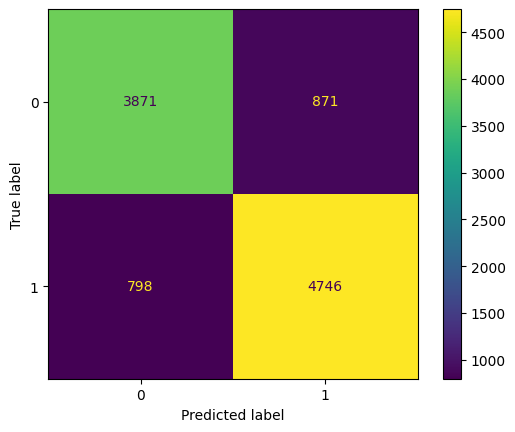

In [ ]:
predictions = trainer.predict(eval_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

print("Classification Report:\n", classification_report(true_labels, predicted_labels))

cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()